In [76]:
from qiskit.circuit.library import QAOAAnsatz

import parity_network
import importlib
import numpy as np

In [77]:
num_qubits = 10

In [78]:
importlib.reload(parity_network)

parity, term_dict = parity_network.main(num_qubits)

parity_ansatz = QAOAAnsatz(parity, reps=2)
parity_ansatz.measure_all()

# parity_ansatz.decompose().draw("mpl")

Parities and Weights of the Hamiltonian:
{'1111110111': 0.002, '1111100111': -0.004, '1111110101': -0.004, '1111100101': 0.008, '1111110110': -0.008, '1111110010': -0.008, '1111110100': 0.008, '0111110111': -0.004, '0111100111': 0.008, '0111110101': 0.008, '0111100101': -0.016, '1101111010': -0.004, '1101101010': 0.008, '1101111000': -0.008, '1101101000': -0.016, '1101111101': -0.002, '1101111001': 0.004, '1101111100': 0.004, '1101110111': -0.004, '1101100111': 0.008, '1101110101': 0.008, '1101100101': -0.016, '0101110111': 0.008, '0101100111': -0.016, '0101110101': -0.016, '0101100101': 0.031, '1110101111': -0.004, '1111111011': 0.004, '1110101011': 0.008, '1111101011': -0.008, '0111101101': -0.016, '1110110101': 0.008, '0111101001': 0.031, '1110101110': 0.008, '1111111010': 0.004, '1110101010': -0.016, '1111101010': 0.016, '1110110100': -0.016, '1110110110': 0.008, '1111100110': -0.008, '1111100010': 0.016, '1100101111': 0.008, '1100101011': -0.016, '1100111101': 0.004, '1100111001':

In [79]:
from qiskit.quantum_info import SparsePauliOp


def get_hamiltonian_observable(term_dict, n_qubits):
    """Converts a dictionary of bitstrings and weights into a Qiskit SparsePauliOp observable."""
    pauli_list = []
    coeff_list = []
    for bitstring, weight in term_dict.items():
        pauli_str = ["I"] * n_qubits
        for i, bit in enumerate(bitstring):
            if bit == "1":
                pauli_str[n_qubits - 1 - i] = "Z"
        pauli_list.append("".join(pauli_str))
        coeff_list.append(weight)

    return SparsePauliOp(pauli_list, coeffs=coeff_list)

In [80]:
from scipy.optimize import minimize
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit.compiler import transpile

backend = AerSimulator()
estimator = AerEstimator()
estimator.options.shots = 10000

parity_ansatz_isa = transpile(parity_ansatz, backend=backend)

obs = get_hamiltonian_observable(term_dict, num_qubits)
print(obs)

SparsePauliOp(['ZZZIZZZZZZ', 'ZZZIIZZZZZ', 'ZIZIZZZZZZ', 'ZIZIIZZZZZ', 'IZZIZZZZZZ', 'IZIIZZZZZZ', 'IIZIZZZZZZ', 'ZZZIZZZZZI', 'ZZZIIZZZZI', 'ZIZIZZZZZI', 'ZIZIIZZZZI', 'IZIZZZZIZZ', 'IZIZIZZIZZ', 'IIIZZZZIZZ', 'IIIZIZZIZZ', 'ZIZZZZZIZZ', 'ZIIZZZZIZZ', 'IIZZZZZIZZ', 'ZZZIZZZIZZ', 'ZZZIIZZIZZ', 'ZIZIZZZIZZ', 'ZIZIIZZIZZ', 'ZZZIZZZIZI', 'ZZZIIZZIZI', 'ZIZIZZZIZI', 'ZIZIIZZIZI', 'ZZZZIZIZZZ', 'ZZIZZZZZZZ', 'ZZIZIZIZZZ', 'ZZIZIZZZZZ', 'ZIZZIZZZZI', 'ZIZIZZIZZZ', 'ZIIZIZZZZI', 'IZZZIZIZZZ', 'IZIZZZZZZZ', 'IZIZIZIZZZ', 'IZIZIZZZZZ', 'IIZIZZIZZZ', 'IZZIZZIZZZ', 'IZZIIZZZZZ', 'IZIIIZZZZZ', 'ZZZZIZIIZZ', 'ZZIZIZIIZZ', 'ZIZZZZIIZZ', 'ZIIZZZIIZZ', 'IZZZIZIIZZ', 'IZIZIZIIZZ', 'IIZZZZIIZZ', 'IIIZZZIIZZ', 'IIZIIZZZZZ', 'IZZIZZZZZI', 'IZZIIZZZZI', 'IIZIZZZZZI', 'IIZIIZZZZI', 'IZZIZIZZZZ', 'IIZIZIZZZZ', 'IZZZIZZZZZ', 'IZIZZIZIZZ', 'IZIZIIZIZZ', 'IIZZIZZZZZ', 'IIIZZIZIZZ', 'IIIZIIZIZZ', 'IZZZIZZZZI', 'IIZZIZZZZI', 'ZZIZZIZZZZ', 'ZZIIZIZZZZ', 'IZZIIZIZZZ', 'IZIZZIZZZZ', 'IZIIZIZZZZ', 'IIZIIZIZZZ', 'IZZI

In [81]:
parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}


def initialize_cost_history_dict(cost_history_dict):
    cost_history_dict["iters"] = 0
    cost_history_dict["cost_history"] = []

In [82]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator, cost_history_dict):

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    cost_history_dict["iters"] += 1
    cost_history_dict["cost_history"].append(cost)
    print(f"Iters {cost_history_dict['iters']}: Current cost: {cost}")

    return cost

In [83]:
params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(parity_cost_history_dict)

result_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, estimator, parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.028166015625
Iters 2: Current cost: -0.004031250000000001
Iters 3: Current cost: 0.019837890625
Iters 4: Current cost: -0.006046875000000001
Iters 5: Current cost: -0.00140234375
Iters 6: Current cost: -0.007970703124999997
Iters 7: Current cost: -0.008585937499999998
Iters 8: Current cost: 0.008236328125000003
Iters 9: Current cost: -0.061650390625
Iters 10: Current cost: -0.042068359374999996
Iters 11: Current cost: -0.06031835937499999
Iters 12: Current cost: -0.004312499999999999
Iters 13: Current cost: -0.02018359375
Iters 14: Current cost: -0.004982421875000001
Iters 15: Current cost: -0.061320312499999995
Iters 16: Current cost: 0.005201171875000002
Iters 17: Current cost: -0.06646484375
Iters 18: Current cost: -0.03408203125
Iters 19: Current cost: -0.030537109374999996
Iters 20: Current cost: -0.05737499999999998
Iters 21: Current cost: -0.06125585937500003
Iters 22: Current cost: -0.051515624999999995
Iters 23: Current cost: -0.06473828125
Iters 24: C

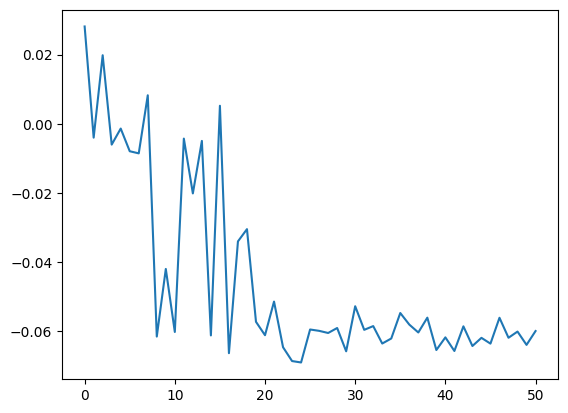

In [84]:
import matplotlib.pyplot as plt

plt.plot(parity_cost_history_dict["cost_history"])

In [85]:
naive_ansatz = QAOAAnsatz(obs, reps=2)
naive_ansatz.measure_all()

# naive_ansatz.decompose().draw("mpl")

In [86]:
naive_ansatz_isa = transpile(naive_ansatz, backend=backend)

In [87]:
naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [88]:
params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(naive_cost_history_dict)

result_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, estimator, naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: -0.015925781250000007
Iters 2: Current cost: 0.02780859375
Iters 3: Current cost: 0.007621093750000002
Iters 4: Current cost: 0.00041796874999999907
Iters 5: Current cost: -0.012898437500000004
Iters 6: Current cost: -0.04622265625
Iters 7: Current cost: 0.022533203125
Iters 8: Current cost: 0.03410742187500001
Iters 9: Current cost: -0.042154296875
Iters 10: Current cost: 0.05715820312499999
Iters 11: Current cost: 0.023904296875000005
Iters 12: Current cost: 0.0019121093749999958
Iters 13: Current cost: -0.05870898437499998
Iters 14: Current cost: -0.044435546875
Iters 15: Current cost: -0.071044921875
Iters 16: Current cost: -0.06590625
Iters 17: Current cost: -0.03508007812500001
Iters 18: Current cost: -0.06077929687499999
Iters 19: Current cost: -0.06139648437499999
Iters 20: Current cost: -0.06026367187499998
Iters 21: Current cost: -0.05876757812499998
Iters 22: Current cost: -0.063212890625
Iters 23: Current cost: -0.06280078125
Iters 24: Current cost: -

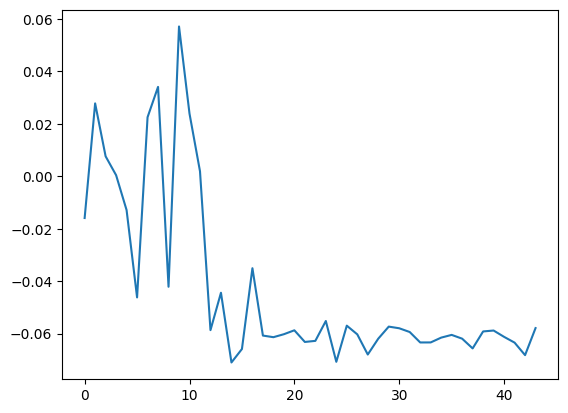

In [89]:
plt.plot(naive_cost_history_dict["cost_history"])

## Noise AerSimulator

In [ ]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

noisy_estimator = AerEstimator(
    options=dict(backend_options=dict(noise_model=noise_model))
)

In [91]:
noisy_parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [92]:
params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(noisy_parity_cost_history_dict)

result_noisy_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, noisy_estimator, noisy_parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.00025976562500000034
Iters 2: Current cost: -0.004191406250000001
Iters 3: Current cost: 0.000916015625
Iters 4: Current cost: 0.005267578125
Iters 5: Current cost: -0.007705078124999999
Iters 6: Current cost: 0.0020039062500000026
Iters 7: Current cost: -0.004654296875
Iters 8: Current cost: -0.0009628906249999989
Iters 9: Current cost: -0.00508984375
Iters 10: Current cost: -0.0037089843750000018
Iters 11: Current cost: -0.001708984375
Iters 12: Current cost: -0.006027343750000001
Iters 13: Current cost: 0.004951171874999999
Iters 14: Current cost: 0.00178515625
Iters 15: Current cost: -0.0019433593749999998
Iters 16: Current cost: 0.001937500000000002
Iters 17: Current cost: 0.0003886718749999997
Iters 18: Current cost: 0.00578125
Iters 19: Current cost: -0.004300781249999999
Iters 20: Current cost: -0.0027304687500000007
Iters 21: Current cost: -0.008931640624999999
Iters 22: Current cost: -0.005240234375000002
Iters 23: Current cost: 0.001263671875
Iters 2

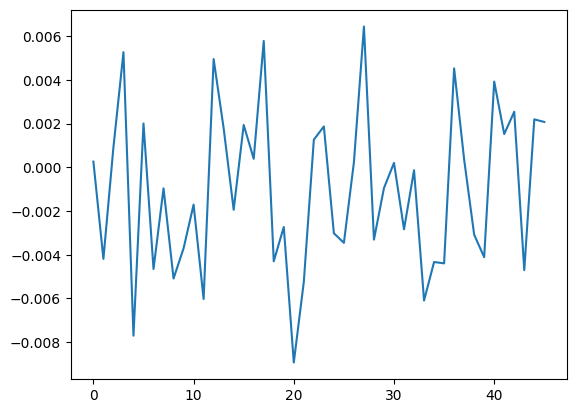

In [93]:
plt.plot(noisy_parity_cost_history_dict["cost_history"])

In [94]:
noisy_naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [95]:
params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(noisy_naive_cost_history_dict)

result_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, noisy_estimator, noisy_naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.003234374999999998
Iters 2: Current cost: -0.006251953124999998
Iters 3: Current cost: 0.004994140625000002
Iters 4: Current cost: -0.002275390624999999
Iters 5: Current cost: 0.0003867187499999997
Iters 6: Current cost: 0.00394921875
Iters 7: Current cost: 0.004677734375
Iters 8: Current cost: -0.004794921875000001
Iters 9: Current cost: -0.007291015625
Iters 10: Current cost: 0.0037558593750000005
Iters 11: Current cost: 0.006265625
Iters 12: Current cost: -0.005244140625
Iters 13: Current cost: -0.006330078125
Iters 14: Current cost: 0.0007285156250000004
Iters 15: Current cost: 0.002369140625000001
Iters 16: Current cost: 0.00027929687500000003
Iters 17: Current cost: -0.004312499999999999
Iters 18: Current cost: 0.0038046875000000008
Iters 19: Current cost: 0.002693359374999999
Iters 20: Current cost: 0.0013808593749999993
Iters 21: Current cost: -0.004986328125
Iters 22: Current cost: -0.003816406250000001
Iters 23: Current cost: 0.002619140625000001
Iter

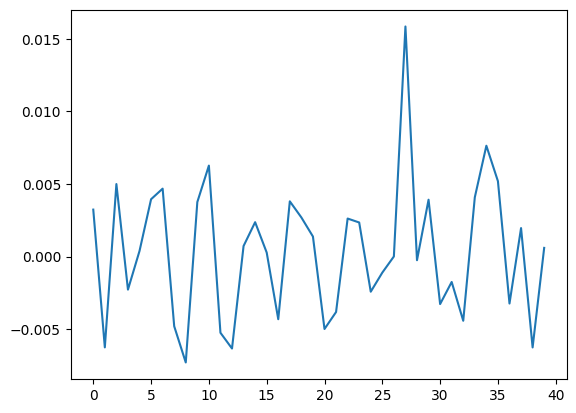

In [96]:
plt.plot(noisy_naive_cost_history_dict["cost_history"])